In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `~/Documents/GaussianProcessNode 2`


In [2]:
using Revise 
using StableRNGs, GraphPPL,ReactiveMP, RxInfer, Random, Distributions, LinearAlgebra, Plots
using Flux, Zygote, ForwardDiff
using SpecialFunctions, ForwardDiff, Optim
using BenchmarkTools
import KernelFunctions: SqExponentialKernel, Matern52Kernel, with_lengthscale, Kernel, kernelmatrix  
import ReactiveMP: GaussHermiteCubature
using Roots
# import Functors: @functor

## Prepare data 

In [3]:
function generate_data(n, f_gp, c_gp, σ_y)
    y=[]
    obs = []
    for i=1:n
        temp = c_gp[i] * exp(f_gp[i]) 
        push!(y,temp)
        push!(obs, temp + σ_y*randn())
    end
    return y , obs
end

generate_data (generic function with 1 method)

In [100]:
Random.seed!(1)
σ_y = 0.1 ## we assume low noise for now

N = 200; #data length
n = 200; #lenght of the axis of gp 
mean_amplitude = (x) -> 1.0;
mean_carrier   = (x) -> 0.0;
kernel_carrier(θ)     = 0.4with_lengthscale(SqExponentialKernel(),θ)
kernel_amplitude(θ)   = 0.1with_lengthscale(Matern52Kernel(),θ)
tmin,tmax = 0., 1.0
time_range = collect(range(tmin, tmax; length=n));


Cov_amplitude = kernelmatrix(kernel_amplitude(0.1),time_range,time_range) + 1e-8*I;
Cov_carrier   = kernelmatrix(kernel_carrier(0.01),time_range,time_range) + 1e-8I;
gp_amplitude  = MvNormal(mean_amplitude.(time_range), Cov_amplitude)
gp_carrier    = MvNormal(mean_carrier.(time_range), Cov_carrier)
amplitude_test = rand(gp_amplitude)
carrier_test   = rand(gp_carrier)
#Observe data 
pos = sort(randperm(n)[1:N]); # position where we observe data
time_train = time_range[pos]
amplitude_train = amplitude_test[pos];
carrier_train   = carrier_test[pos]
cov_strategy = CovarianceMatrixStrategy(FullCovarianceStrategy())
# cov_strategy = CovarianceMatrixStrategy(SoR(50))

CovarianceMatrixStrategy{FullCovarianceStrategy{Vector{Int64}, Nothing}}(FullCovarianceStrategy{Vector{Int64}, Nothing}(Int64[], nothing, [1.0;;], ReactiveMP.GPCache(Dict{Tuple{Symbol, Tuple{Int64, Int64}}, Matrix{Float64}}(), Dict{Tuple{Symbol, Int64}, Vector{Float64}}())))

In [101]:
kernelmatrix(kernel_carrier(0.1),time_range,time_range)

200×200 Matrix{Float64}:
 0.4          0.399495     0.397985     …  1.27358e-22  7.715e-23
 0.399495     0.4          0.399495        2.0971e-22   1.27358e-22
 0.397985     0.399495     0.4             3.44442e-22  2.0971e-22
 0.39548      0.397985     0.399495        5.64308e-22  3.44442e-22
 0.392        0.39548      0.397985        9.22188e-22  5.64308e-22
 0.387571     0.392        0.39548      …  1.50323e-21  9.22188e-22
 0.382226     0.387571     0.392           2.4442e-21   1.50323e-21
 0.376003     0.382226     0.387571        3.96415e-21  2.4442e-21
 0.368949     0.376003     0.382226        6.41308e-21  3.96415e-21
 0.361114     0.368949     0.376003        1.03487e-20  6.41308e-21
 0.352554     0.361114     0.368949     …  1.66575e-20  1.03487e-20
 0.343329     0.352554     0.361114        2.67446e-20  1.66575e-20
 0.333503     0.343329     0.352554        4.28318e-20  2.67446e-20
 ⋮                                      ⋱               
 1.66575e-20  2.67446e-20  4.28318e-20

In [102]:
#Generate data 
y_true_state,y_data = generate_data(N,amplitude_train,carrier_train,σ_y);

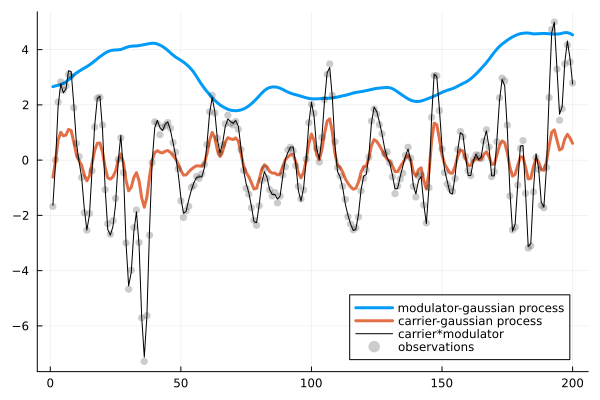

In [103]:
plot(exp.(amplitude_train), label="modulator-gaussian process",linewidth=3.0)
plot!(carrier_train,label="carrier-gaussian process",linewidth=3.0)
plot!(exp.(amplitude_train).*carrier_train,label="carrier*modulator",color=:black)

scatter!(y_data, color=:black,label = "observations",alpha=0.2)

## Specify model

In [104]:
#Exponentiate function 
struct MyExponential end

@node MyExponential Deterministic [ y, x ]   ## x: input,  y: output

In [117]:
### rule for y 
##TODO: this rule needs to be investigated for speed vs. accuracy 
@rule MyExponential(:y, Marginalisation) (m_x::GaussianProcess, meta::ProcessMeta) = begin
    index = meta.index
    m_gp, cov_gp = mean_cov(m_x.finitemarginal)
#     μ_in = m_gp[index]
#     @show index
#     var_in = cov_gp[index,index]
    kernelf = m_x.kernelfunction
    meanf   = m_x.meanfunction
    test    = m_x.testinput
    train   = m_x.traininput
    cov_strategy = m_x.covariance_strategy
    x_u = m_x.inducing_input
    mμ, var_μ = ReactiveMP.predictMVN(cov_strategy, kernelf,meanf,test,[train[index]],m_gp, x_u) #this returns negative variance 
    μ_in = mμ[1]
    var_μ[1] < 0. ? var_in = 1 : var_in = var_μ[1]
#     if any(isnan.([μ_in, var_in] )) == true
# #         @show "here"
#           @show μ_in = m_gp[index]
#         @show var_in = cov_gp[index,index]
#     end
    
    return LogNormal(μ_in, var_in)
end

### rule for x
@rule MyExponential(:x, Marginalisation) (m_y::ContinuousUnivariateLogPdf, meta::ProcessMeta) = begin
    log_pdf = (x) -> logpdf(m_y,exp(x))
    return ContinuousUnivariateLogPdf(log_pdf)
end

@rule MyExponential(:x, Marginalisation) (m_y::ContinuousUnivariateLogPdf,m_x::GaussianDistributionsFamily, meta::ProcessMeta) = begin
    log_pdf = (x) -> logpdf(m_y,exp(x)) + 1e-8
#     xsamples = rand(m_x, 10000)
#     weight   = exp.(log_pdf.(xsamples)) / sum(exp.(log_pdf.(xsamples)))
#     m_       = sum(weight .* xsamples)
#     v_       = sum(weight .* (xsamples .- m_).^2)
    
  
    
    meta = GaussHermiteCubature(121)
    m_,v_ = ReactiveMP.approximate_meancov(meta, z -> exp(log_pdf(z)), mean(m_x), var(m_x))
    ksi = m_/v_ - weightedmean(m_x)
    precision = clamp(1/v_ - precision(m_x),0.0001,100.0)
    
    
    return NormalWeightedMeanPrecision(ksi,precision)
end


@rule MyExponential(:x, Marginalisation) (m_y::ContinuousUnivariateLogPdf, m_x::GaussianProcess, meta::ProcessMeta) = begin 
    index = meta.index
    m_gp, cov_gp = mean_cov(m_x.finitemarginal)
    kernelf = m_x.kernelfunction
    meanf   = m_x.meanfunction
    test    = m_x.testinput
    train   = m_x.traininput
    cov_strategy = m_x.covariance_strategy
    x_u = m_x.inducing_input
    mμ, var_μ = ReactiveMP.predictMVN(cov_strategy, kernelf,meanf,test,[train[index]],m_gp, x_u) #this returns negative variance 
    μ_in = mμ[1]
    var_μ[1] < 0. ? var_in = 1 : var_in = var_μ[1]
    
    log_pdf = (x) -> logpdf(m_y,exp(x)) + 1e-8

    
    meta = GaussHermiteCubature(121)
    m_,v_ = ReactiveMP.approximate_meancov(meta, z -> exp(log_pdf(z)), μ_in, var_in)
    
    
     
    ksi = m_/v_ - μ_in/var_in
    precision = clamp(1/v_ - 1/var_in,0.00001,100.0)
    
    return NormalWeightedMeanPrecision(ksi,precision)
end


@rule MyExponential(:y, Marginalisation) (m_x::UnivariateGaussianDistributionsFamily, meta::ProcessMeta) = begin 
    return LogNormal(mean(m_x), var(m_x))
end
    
@rule MyExponential(:x, Marginalisation) (m_y::UnivariateGaussianDistributionsFamily, meta::ProcessMeta) = begin 
    log_pdf = (x) -> logpdf(m_y,exp(x))
    return ContinuousUnivariateLogPdf(log_pdf)
end

In [118]:
#Test with GP with fixed hyperparameters
@model function modulation(n, amplitude_kernel,amplitude_mean, carrier_kernel, carrier_mean,train,test, gpstrategy)
    amplitude   = randomprocess(test, train, gpstrategy)
    carrier     = randomprocess(test, train, gpstrategy)
    observation = datavar(Float64,n)
    g = randomvar(n)
    w = randomvar(n)

    amplitude ~ GaussianProcess(amplitude_mean, amplitude_kernel, log(0.1))
    carrier   ~ GaussianProcess(carrier_mean, carrier_kernel, log(0.01))
    for i=1:n 
        g[i] ~ MyExponential(amplitude) where {meta = ProcessMeta(i),pipeline = RequireMessage(x = NormalMeanPrecision(1.0, 0.1))}
#         g[i] ~ MyExponential(amplitude) where {meta = ProcessMeta(i)}
        w[i] ~ *(carrier, g[i]) where {meta = ProcessMeta(i)}
        observation[i] ~ NormalMeanPrecision(w[i], 1/σ_y^2)
    end
end

In [119]:
@rule typeof(*)(:A, Marginalisation) (m_out::UnivariateGaussianDistributionsFamily, m_in::Tuple, meta::TinyCorrection) = begin 
    μ_in = mean(m_in[1])
    var_in = mean(m_in[2])
    
    μ_out, var_out = mean_var(m_out)
    backwardpass = (x) -> -log(abs(x)+1e-8) - 0.5*log(2π * (var_in + var_out / x^2))  -1/2 * (μ_out / x - μ_in)^2 / (var_in + var_out / x^2)
    return ContinuousUnivariateLogPdf(backwardpass)
end

@rule typeof(*)(:in, Marginalisation) (m_out::UnivariateGaussianDistributionsFamily, m_A::UnivariateGaussianDistributionsFamily, meta::TinyCorrection) = begin 
    μ_in, var_in = mean_var(m_A)
    μ_out, var_out = mean_var(m_out)
    backwardpass = (x) -> -log(abs(x)+1e-8) - 0.5*log(2π * (var_in + var_out / x^2))  - 1/2 * (μ_out / x - μ_in)^2 / (var_in + var_out / x^2)

    return ContinuousUnivariateLogPdf(backwardpass)
end



## Rule for multiplication node

In [120]:
#use Gaussian GaussHermiteCubature to approximate 
#Temporarily put here 
function ReactiveMP.prod(::ProdAnalytical, left::UnivariateGaussianDistributionsFamily, right::ContinuousUnivariateLogPdf) 
    #we use Gaussian Hermite Cubature here, not ProdAnalytical 
    meta = GaussHermiteCubature(121)
    m,v = ReactiveMP.approximate_meancov(meta, z -> exp(right.logpdf(z)+1e-7), mean(left), var(left))
    return NormalMeanVariance(m,v)
end

function ReactiveMP.prod(::ProdAnalytical, left::ContinuousUnivariateLogPdf, right::UnivariateGaussianDistributionsFamily)
    meta = GaussHermiteCubature(121)
    m,v = ReactiveMP.approximate_meancov(meta, z -> exp(left.logpdf(z)+1e-7), mean(right), var(right))
    return NormalMeanVariance(m,v)
end

#Look carefully at these two functions 
function ReactiveMP.mean_var(p::ContinuousUnivariateLogPdf)
    f = x -> ForwardDiff.derivative(p.logpdf,x) + 1e-7
    m0 = find_zeros(f,-10,10)
    
    if isempty(m0) == true || any(isnan.(m0)) == true
        res = optimize(x->-logpdf(p,x),-10,10)
        m0 = res.minimizer
    else
        m0 = m0[1]
    end
#     res = optimize(x->-logpdf(p,x),-5,5)
#     @show m0 = res.minimizer
    
    meta = GaussHermiteCubature(221)
    v0 =  10.0
    m,v = ReactiveMP.approximate_meancov(meta, z -> exp(p.logpdf(z)-logpdf(NormalMeanVariance(m0,v0),z)), m0, v0)
    
    return m,v
end

Distributions.mean(p::ContinuousUnivariateLogPdf) = mean_var(p)[1]
Distributions.var(p::ContinuousUnivariateLogPdf) = mean_var(p)[2]


function ReactiveMP.prod(::ProdAnalytical, left::LogNormal, right::ContinuousUnivariateLogPdf) 
    sample_left = rand(left,10000)
    weights = [exp(logpdf(right,sample_left[i])+1e-8) for i=1:length(sample_left)]
    weight = weights / sum(weights)
    m = sum(weight .* log.(sample_left))
    v = sum(weight .* (log.(sample_left) .- m).^2)
    
#     μ = log(m^2/sqrt(m^2+v))
#     w = log(1+v/m^2)
    
    return LogNormal(m,v)
end

@rule NormalMeanVariance(:v, Marginalisation) (m_out::ContinuousUnivariateLogPdf, q_μ::PointMass, ) = begin 
    m,v = mean_var(m_out)
    d_out = NormalMeanVariance(m,v)
    return @call_rule NormalMeanVariance(:v, Marginalisation) (q_out=d_out, q_μ=q_μ, ) 
end

@rule NormalMeanVariance(:out, Marginalisation) (q_μ::PointMass, m_v::InverseGamma, ) = begin 
    return  @call_rule NormalMeanVariance(:out, Marginalisation) (q_μ=q_μ, q_v=m_v, )
end

@rule NormalMeanPrecision(:τ, Marginalisation) (m_out::ContinuousUnivariateLogPdf, q_μ::PointMass, ) = begin 
    m,v = mean_var(m_out)
    d_out = NormalMeanVariance(m,v)
    return @call_rule NormalMeanPrecision(:τ, Marginalisation) (q_out=d_out, q_μ =q_μ , )
end

@rule NormalMeanPrecision(:out, Marginalisation) (q_μ::PointMass, m_τ::Gamma, ) = begin 
    return  @call_rule NormalMeanPrecision(:out, Marginalisation) (q_μ=q_μ, q_τ=m_τ, )
end

@rule GaussianProcess(:params, Marginalisation) (m_out::GaussianProcess, q_meanfunc::PointMass, q_kernelfunc::PointMass, q_params::UnivariateGaussianDistributionsFamily, meta::Unscented) = begin 
    return @call_rule GaussianProcess(:params, Marginalisation) (q_out=m_out, q_meanfunc=q_meanfunc, q_kernelfunc=q_kernelfunc, q_params=q_params, meta=meta)
end

@rule typeof(*)(:A, Marginalisation) (m_out::UnivariateGaussianDistributionsFamily, m_in::LogNormal, meta::ProcessMeta) = begin 
    return @call_rule typeof(*)(:A, Marginalisation) (m_out=m_out,m_in=m_in)
end

@rule typeof(*)(:A, Marginalisation) (m_out::UnivariateGaussianDistributionsFamily, m_in::LogNormal, ) = begin 
    dist_in = NormalMeanVariance(mean(m_in),var(m_in))
    return @call_rule typeof(*)(:in, Marginalisation) (m_out=m_out,m_A=dist_in,meta=TinyCorrection())
end


@rule typeof(*)(:in, Marginalisation) (m_out::NormalMeanPrecision, m_A::GaussianProcess, meta::ProcessMeta) = begin 
    
    index = meta.index
    m_gp, cov_gp = mean_cov(m_A.finitemarginal)
    kernelf = m_A.kernelfunction
    meanf   = m_A.meanfunction
    test    = m_A.testinput
    train   = m_A.traininput
    cov_strategy = m_A.covariance_strategy
    x_u = m_A.inducing_input
    mμ, var_μ = ReactiveMP.predictMVN(cov_strategy, kernelf,meanf,test,[train[index]],m_gp, x_u) #this returns negative variance 
    μ_in = mμ[1]
    var_μ[1] < 0. ? var_in = 1 : var_in = var_μ[1]
#     @show var_μ
    d_A = NormalMeanVariance(μ_in, var_in)
    
    
    return @call_rule typeof(*)(:in, Marginalisation) (m_out=m_out,m_A=d_A,meta=TinyCorrection())
end



In [121]:
nits = 2

iresult = inference(
    model = modulation(length(y_data), kernel_amplitude,mean_amplitude, kernel_carrier,mean_carrier, time_train,time_range, cov_strategy),
    initmessages = (amplitude = GaussianProcess(mean_amplitude,kernel_amplitude(0.1),MvNormalMeanCovariance(ones(n),Cov_amplitude),time_range,time_train,Float64[], CovarianceMatrixStrategy(FullCovarianceStrategy())),),
    iterations = nits, 
    returnvars = (amplitude=KeepEach(),carrier=KeepEach()),
    data  = (observation = y_data,),
    showprogress = true,
    free_energy = false
)


map!(meanfunc, xtest_transformed, xtest) = [1.0]
map!(meanfunc, xtest_transformed, xtest) = [1.0]
map!(meanfunc, xtest_transformed, xtest) = [1.0]
map!(meanfunc, xtest_transformed, xtest) = [1.0]
map!(meanfunc, xtest_transformed, xtest) = [1.0]
map!(meanfunc, xtest_transformed, xtest) = [1.0]
map!(meanfunc, xtest_transformed, xtest) = [1.0]
map!(meanfunc, xtest_transformed, xtest) = [1.0]
map!(meanfunc, xtest_transformed, xtest) = [1.0]
map!(meanfunc, xtest_transformed, xtest) = [1.0]
map!(meanfunc, xtest_transformed, xtest) = [1.0]
map!(meanfunc, xtest_transformed, xtest) = [1.0]
map!(meanfunc, xtest_transformed, xtest) = [1.0]
map!(meanfunc, xtest_transformed, xtest) = [1.0]
map!(meanfunc, xtest_transformed, xtest) = [1.0]
map!(meanfunc, xtest_transformed, xtest) = [1.0]
map!(meanfunc, xtest_transformed, xtest) = [1.0]
map!(meanfunc, xtest_transformed, xtest) = [1.0]
map!(meanfunc, xtest_transformed, xtest) = [1.0]
map!(meanfunc, xtest_transformed, xtest) = [1.0]
map!(meanfunc, xtest

map!(meanfunc, xtest_transformed, xtest) = [1.0]
map!(meanfunc, xtest_transformed, xtest) = [1.0]
map!(meanfunc, xtest_transformed, xtest) = [1.0]
map!(meanfunc, xtest_transformed, xtest) = [1.0]
map!(meanfunc, xtest_transformed, xtest) = [1.0]
map!(meanfunc, xtest_transformed, xtest) = [1.0]
map!(meanfunc, xtest_transformed, xtest) = [1.0]
map!(meanfunc, xtest_transformed, xtest) = [1.0]
map!(meanfunc, xtest_transformed, xtest) = [1.0]
map!(meanfunc, xtest_transformed, xtest) = [1.0]
map!(meanfunc, xtest_transformed, xtest) = [1.0]
map!(meanfunc, xtest_transformed, xtest) = [1.0]
map!(meanfunc, xtest_transformed, xtest) = [1.0]
map!(meanfunc, xtest_transformed, xtest) = [1.0]
map!(meanfunc, xtest_transformed, xtest) = [1.0]
map!(meanfunc, xtest_transformed, xtest) = [1.0]
map!(meanfunc, xtest_transformed, xtest) = [1.0]
map!(meanfunc, xtest_transformed, xtest) = [1.0]
map!(meanfunc, xtest_transformed, xtest) = [1.0]
map!(meanfunc, xtest_transformed, xtest) = [1.0]
map!(meanfunc, xtest

map!(meanfunc, xtest_transformed, xtest) = [1.0]
map!(meanfunc, xtest_transformed, xtest) = [1.0]
map!(meanfunc, xtest_transformed, xtest) = [1.0]
map!(meanfunc, xtest_transformed, xtest) = [1.0]
map!(meanfunc, xtest_transformed, xtest) = [1.0]
map!(meanfunc, xtest_transformed, xtest) = [1.0]
map!(meanfunc, xtest_transformed, xtest) = [1.0]
map!(meanfunc, xtest_transformed, xtest) = [1.0]
map!(meanfunc, xtest_transformed, xtest) = [1.0]
map!(meanfunc, xtest_transformed, xtest) = [1.0]
map!(meanfunc, xtest_transformed, xtest) = [1.0]
map!(meanfunc, xtest_transformed, xtest) = [1.0]
map!(meanfunc, xtest_transformed, xtest) = [1.0]
map!(meanfunc, xtest_transformed, xtest) = [1.0]
map!(meanfunc, xtest_transformed, xtest) = [1.0]
map!(meanfunc, xtest_transformed, xtest) = [1.0]
map!(meanfunc, xtest_transformed, xtest) = [1.0]
map!(meanfunc, xtest_transformed, xtest) = [1.0]
map!(meanfunc, xtest_transformed, xtest) = [1.0]
map!(meanfunc, xtest_transformed, xtest) = [1.0]
map!(meanfunc, xtest

map!(meanfunc, xtest_transformed, xtest) = [1.0]
map!(meanfunc, xtest_transformed, xtest) = [1.0]
map!(meanfunc, xtest_transformed, xtest) = [1.0]
map!(meanfunc, xtest_transformed, xtest) = [1.0]
map!(meanfunc, xtest_transformed, xtest) = [1.0]
map!(meanfunc, xtest_transformed, xtest) = [1.0]
map!(meanfunc, xtest_transformed, xtest) = [1.0]
map!(meanfunc, xtest_transformed, xtest) = [1.0]
map!(meanfunc, xtest_transformed, xtest) = [1.0]
map!(meanfunc, xtest_transformed, xtest) = [1.0]
map!(meanfunc, xtest_transformed, xtest) = [1.0]
map!(meanfunc, xtest_transformed, xtest) = [1.0]
map!(meanfunc, xtest_transformed, xtest) = [1.0]
map!(meanfunc, xtest_transformed, xtest) = [1.0]
map!(meanfunc, xtest_transformed, xtest) = [1.0]
map!(meanfunc, xtest_transformed, xtest) = [1.0]
map!(meanfunc, xtest_transformed, xtest) = [1.0]
map!(meanfunc, xtest_transformed, xtest) = [1.0]
map!(meanfunc, xtest_transformed, xtest) = [1.0]
map!(meanfunc, xtest_transformed, xtest) = [1.0]
map!(meanfunc, xtest

map!(meanfunc, xtest_transformed, xtest) = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0

map!(meanfunc, xtest_transformed, xtest) = [0.0]
map!(meanfunc, xtest_transformed, xtest) = [0.0]
map!(meanfunc, xtest_transformed, xtest) = [0.0]
map!(meanfunc, xtest_transformed, xtest) = [0.0]
map!(meanfunc, xtest_transformed, xtest) = [0.0]
map!(meanfunc, xtest_transformed, xtest) = [0.0]
map!(meanfunc, xtest_transformed, xtest) = [0.0]
map!(meanfunc, xtest_transformed, xtest) = [0.0]
map!(meanfunc, xtest_transformed, xtest) = [0.0]
map!(meanfunc, xtest_transformed, xtest) = [0.0]
map!(meanfunc, xtest_transformed, xtest) = [0.0]
map!(meanfunc, xtest_transformed, xtest) = [0.0]
map!(meanfunc, xtest_transformed, xtest) = [0.0]
map!(meanfunc, xtest_transformed, xtest) = [0.0]
map!(meanfunc, xtest_transformed, xtest) = [0.0]
map!(meanfunc, xtest_transformed, xtest) = [0.0]
map!(meanfunc, xtest_transformed, xtest) = [0.0]
map!(meanfunc, xtest_transformed, xtest) = [0.0]
map!(meanfunc, xtest_transformed, xtest) = [0.0]
map!(meanfunc, xtest_transformed, xtest) = [0.0]
map!(meanfunc, xtest

map!(meanfunc, xtest_transformed, xtest) = [1.0]
map!(meanfunc, xtest_transformed, xtest) = [1.0]
map!(meanfunc, xtest_transformed, xtest) = [1.0]
map!(meanfunc, xtest_transformed, xtest) = [1.0]
map!(meanfunc, xtest_transformed, xtest) = [1.0]
map!(meanfunc, xtest_transformed, xtest) = [1.0]
map!(meanfunc, xtest_transformed, xtest) = [1.0]
map!(meanfunc, xtest_transformed, xtest) = [1.0]
map!(meanfunc, xtest_transformed, xtest) = [1.0]
map!(meanfunc, xtest_transformed, xtest) = [1.0]
map!(meanfunc, xtest_transformed, xtest) = [1.0]
map!(meanfunc, xtest_transformed, xtest) = [1.0]
map!(meanfunc, xtest_transformed, xtest) = [1.0]
map!(meanfunc, xtest_transformed, xtest) = [1.0]
map!(meanfunc, xtest_transformed, xtest) = [1.0]
map!(meanfunc, xtest_transformed, xtest) = [1.0]
map!(meanfunc, xtest_transformed, xtest) = [1.0]
map!(meanfunc, xtest_transformed, xtest) = [1.0]
map!(meanfunc, xtest_transformed, xtest) = [1.0]
map!(meanfunc, xtest_transformed, xtest) = [1.0]
map!(meanfunc, xtest

LoadError: DomainError with NaN:
LogNormal: the condition σ ≥ zero(σ) is not satisfied.

In [80]:
mamplitude = mean(iresult.posteriors[:amplitude][end].finitemarginal)
vamplitude = var(iresult.posteriors[:amplitude][end].finitemarginal)
expvgp = exp.( mamplitude .+ vamplitude)
expmgp = exp.(mamplitude);

mcarriers = mean(iresult.posteriors[:carrier][end].finitemarginal)
vcarriers = var(iresult.posteriors[:carrier][end].finitemarginal);

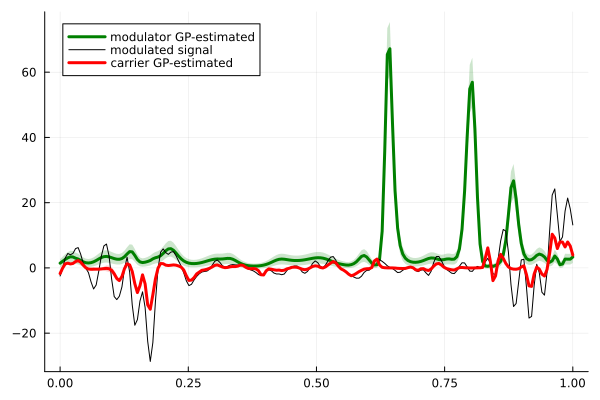

In [72]:
plot(time_range,expmgp,ribbon=sqrt.(expvgp),linewidth=3.0,label="modulator GP-estimated",fillalpha=0.2,color=:green)
# plot!(time_range,-expmgp,ribbon=sqrt.(expvgp),linewidth=3.0,label="modulator GP-estimated",fillalpha=0.2,color=:green)
# plot!(time_range,exp.(amplitude_test), label="modulator GP-true",linewidth=3.0,color=:blue)
plot!(time_train,y_true_state, label="modulated signal",color=:black)
plot!(time_range,mcarriers,ribbon=(vcarriers),linewidth=3.0,label="carrier GP-estimated",fillalpha=0.2,color=:red)
# scatter!(time_train,y_data, label="observation",color=:black,alpha=0.4,ms=3,legend=:bottomleft)
